In [86]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [87]:
df = pd.read_csv("DataSet.csv")
closed_prices = df["Close"]

# The model is trained on 15-day historical prices to predict the next day's price.
seq_len = 15


In [88]:
#Closing price is normalised. The data is reshaped with [..., None] to add a new axis required by MinMaxScaler.
mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()


In [89]:
X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])


In [90]:
#Adds an additional dimension to both X and y to make them compatible with PyTorch.
X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [91]:
#Splits data into training (80%) and testing (20%) sets and converts them to PyTorch tensors.
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [92]:
#A custom LSTM model with input size=1 and hidden size=64

class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 64)

In [93]:
#Adam optimizer to minimize the loss
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()
num_epochs = 100

for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())


10 epoch loss 0.004575652
20 epoch loss 0.003137506
30 epoch loss 0.0005172528
40 epoch loss 0.00016958696
50 epoch loss 2.5487767e-05
60 epoch loss 2.5732092e-05
70 epoch loss 2.4467847e-05
80 epoch loss 2.3443376e-05
90 epoch loss 2.318788e-05


In [94]:
model.eval()
with torch.no_grad():
    output = model(test_x)

In [95]:
#MinMax to original scale
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

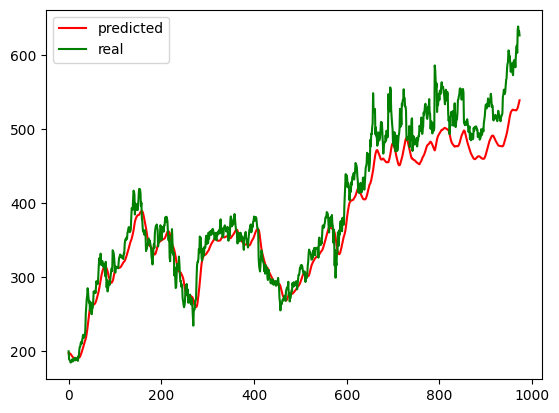

In [96]:
plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.plot(real.squeeze() , color = "green" , label = "real")
plt.legend()
plt.show()
